<a href="https://colab.research.google.com/github/KunikataJun/uth-bert-keras-colab/blob/master/UTH_BERT_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTH-BERT を Tensorflow2.X / Keras BERT から利用して文書分類を行う

公式サイト

- [BERT(Google)](https://github.com/google-research/bert)

- [UTH-BERT](https://ai-health.m.u-tokyo.ac.jp/uth-bert) \([東京大学 医療AI開発学講座](https://ai-health.m.u-tokyo.ac.jp/)\)

- [Keras BERT](https://github.com/CyberZHG/keras-bert)

## 必要なライブラリ等の準備

### pythonライブラリのインストールとインポート

In [ ]:
!pip install keras_bert
!pip install mecab-python3
!pip install jaconv
!pip install neologdn

  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none-any.whl size=34145 sha256=e78c4466bb607a71e3349902c90eaaea28f6cbd95fded87cad91d431f831813a
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for keras-transformer: filename=keras_transformer-0.38.0-cp36-none-any.whl size=12942 sha256=ec72c2e26f5c4411b37c98790b420541b5d9966538ffd98692277adc9b8ea44e
  Stored in directory: /root/.cache/pip/wheels/e5/fb/3a/37b2b9326c799aa010ae46a04ddb04f320d8c77c0b7e837f4e
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=8ec4b9b033957fb633d291185cb286343b4d3e3928d336f1b21b015fe04edc3b
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.27.0-cp36-none-any.whl size=15612 sha256=d0474676b5b0846fee73ef9ccb566dd1f9e7bce5c7589f6b2b73d1a02154a129
  Stor

In [ ]:
import os, sys
import tensorflow as tf
import pandas as pd
import numpy as np
import keras_bert

In [ ]:
# tensorflowのバージョンを確認(2.3.0で動作確認済み)
tf.__version__

'2.3.0'

In [ ]:
# Keras BERTのバージョンを確認（0.86.0で動作確認済み）
keras_bert.__version__

'0.86.0'

In [ ]:
# Keras BERT で tf.keras を使用するための環境変数を設定
os.environ['TF_KERAS'] = '1'

### その他のライブラリとデータセットのダウンロードとインストール

In [ ]:
# UTH-BERT
!wget https://ai-health.m.u-tokyo.ac.jp/labweb/dl/uth_bert/UTH_BERT_BASE_MC_BPE_V25000_10M.zip
!unzip UTH_BERT_BASE_MC_BPE_V25000_10M.zip
!rm UTH_BERT_BASE_MC_BPE_V25000_10M.zip
!git clone https://github.com/jinseikenai/uth-bert.git

# MeCab & NEologd
!apt install mecab libmecab-dev mecab-ipadic-utf8 file
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -a -y # 公式では -a オプションはついていないが多分必要
os.environ['MECABRC'] = "/etc/mecabrc" # 環境変数でmecabrcの場所を指定

# 万病辞書
!wget http://sociocom.jp/~data/2018-manbyo/data/MANBYO_201907_Dic-utf8.dic

# KNBコーパス
!wget http://nlp.ist.i.kyoto-u.ac.jp/kuntt/KNBC_v1.0_090925_utf8.tar.bz2
!tar -jxvf KNBC_v1.0_090925_utf8.tar.bz2
!rm KNBC_v1.0_090925_utf8.tar.bz2

ストリーミング出力は最後の 5000 行に切り捨てられました。
KNBC_v1.0_090925_utf8/html/KN218_Gourmet_1-1-3-01.html
KNBC_v1.0_090925_utf8/html/KN221_Keitai_1-1-12-01-morph.html
KNBC_v1.0_090925_utf8/html/KN012_Sports_2-1-31-01.html
KNBC_v1.0_090925_utf8/html/KN215_Kyoto_1-1-26-01.html
KNBC_v1.0_090925_utf8/html/KN213_Keitai_1-1-3-01-morph.html
KNBC_v1.0_090925_utf8/html/KN039_Kyoto_1-1-28-01-morph.html
KNBC_v1.0_090925_utf8/html/KN238_Gourmet_1-1-26-01-morph.html
KNBC_v1.0_090925_utf8/html/KN217_Kyoto_1-1-20-01.html
KNBC_v1.0_090925_utf8/html/KN242_Kyoto_2-1-20-01.html
KNBC_v1.0_090925_utf8/html/KN209_Keitai_1-1-56-01-morph.html
KNBC_v1.0_090925_utf8/html/KN255_Kyoto_1-1-8-01-morph.html
KNBC_v1.0_090925_utf8/html/KN258_Keitai_1-1-8-02-morph.html
KNBC_v1.0_090925_utf8/html/KN002_Keitai_1-1-2-01-morph.html
KNBC_v1.0_090925_utf8/html/KN025_Kyoto_1-1-7-01-morph.html
KNBC_v1.0_090925_utf8/html/KN243_Gourmet_1-1-7-01-morph.html
KNBC_v1.0_090925_utf8/html/KN205_Gourmet_2-1-4-01-morph.html
KNBC_v1.0_090925_utf8/html/KN003

## ディレクトリ・ファイルへのパスを設定

In [ ]:
# データセット
knbc_dir_path = 'KNBC_v1.0_090925_utf8'
gourmet_tsv_file_path = os.path.join(knbc_dir_path, 'corpus2/Gourmet.tsv')
keitai_tsv_file_path = os.path.join(knbc_dir_path, 'corpus2/Keitai.tsv')
kyoto_tsv_file_path = os.path.join(knbc_dir_path, 'corpus2/Kyoto.tsv')
sports_tsv_file_path = os.path.join(knbc_dir_path, 'corpus2/Sports.tsv')

# 訓練済みモデル
pretrained_model_dir_path = 'UTH_BERT_BASE_MC_BPE_V25000_10M'
pretrained_bert_config_file_path = os.path.join(pretrained_model_dir_path, 'bert_config.json')
pretrained_model_checkpoint_path = os.path.join(pretrained_model_dir_path, 'model.ckpt-10000000') # 拡張子不要
pretrained_vocab_file_path = os.path.join(pretrained_model_dir_path, 'vocab.txt')

# 今回学習するモデル
!mkdir train_model
train_model_dir_path = 'train_model'
train_bert_config_file_path = os.path.join(train_model_dir_path, 'train_bert_config.json')
train_model_checkpoint_path = os.path.join(train_model_dir_path, 'train_model.ckpt')

# NEologd辞書ディレクトリへのパス
import subprocess
cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
neologd_dic_dir_path = subprocess.check_output(cmd, shell=True).decode('utf-8').strip()

# 万病辞書へのパス
manbyo_dic_path = 'MANBYO_201907_Dic-utf8.dic'

## KNBコーパスから今回用いるデータを抽出

In [ ]:
# 各カテゴリのtsvファイルを読み込んでラベル列を追加
df_gourmet = pd.read_table(gourmet_tsv_file_path, header=None)
df_gourmet['label'] = 'グルメ'

df_keitai = pd.read_table(keitai_tsv_file_path, header=None)
df_keitai['label'] = '携帯電話'

df_kyoto = pd.read_table(kyoto_tsv_file_path, header=None)
df_kyoto['label'] = '京都観光'

df_sports = pd.read_table(sports_tsv_file_path, header=None)
df_sports['label'] = 'スポーツ'

# 結合して必要な列だけ抽出
df_dataset = pd.concat([df_gourmet, df_keitai, df_kyoto, df_sports])[[1, 'label']]
df_dataset.columns = ['text', 'label'] # ラベル名変更
df_dataset

,text,label
0,［グルメ］烏丸六角のおかき屋さん,グルメ
1,六角堂の前にある、蕪村庵というお店に行ってきた。,グルメ
2,おかきやせんべいの店なのだが、これがオイシイ。,グルメ
3,のれんをくぐると小さな庭があり、その先に町屋風の店内がある。,グルメ
4,せんべいの箱はデパートみたいな山積みではなく、間隔をあけて陳列されているのがまた良い。,グルメ
...,...,...
517,筋力が違う！！,スポーツ
518,なんか神様、不公平・・・,スポーツ
519,男性諸君、このこと忘れないでやぁ（＞◆＜）,スポーツ
520,まぁ。。。,スポーツ


### 学習用データとテスト用データに分割

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_dataset, test_size=500)

## 前処理用プログラムの動作確認

Tensorflow 2.X では tokenization_mod.py の tf.gfile.GFile を tf.io.gfile.GFile に変更しないとエラーになるので書き換える

In [ ]:
# sed コマンドで tf.gfile.GFile を tf.io.gfile.GFile に置換
!sed -i-e 's/tf\.gfile\.GFile/tf\.io\.gfile\.GFile/g' ./uth-bert/tokenization_mod.py

https://github.com/jinseikenai/uth-bert の [example_main.py](https://github.com/jinseikenai/uth-bert/blob/master/example_main.py) の内容が実行できることを確認

In [ ]:
sys.path.append('uth-bert')
from preprocess_text import preprocess as my_preprocess
from tokenization_mod import MecabTokenizer, FullTokenizerForMecab

if __name__ == '__main__':

    # special token for a Person's name (Do not change)
    name_token = "＠＠Ｎ"

    # path to the mecab-ipadic-neologd
    #mecab_ipadic_neologd = '/usr/lib/mecab/dic/mecab-ipadic-neologd' # 変更
    mecab_ipadic_neologd = neologd_dic_dir_path

    # path to the J-Medic (We used MANBYO_201907_Dic-utf8.dic)
    #mecab_J_medic = './MANBYO_201907_Dic-utf8.dic' # 変更
    mecab_J_medic = manbyo_dic_path

    # path to the uth-bert vocabulary
    #vocab_file = "./bert_vocab_mc_v1_25000.txt" # 変更
    vocab_file = pretrained_vocab_file_path

    # MecabTokenizer
    sub_tokenizer = MecabTokenizer(mecab_ipadic_neologd=mecab_ipadic_neologd,
                                   mecab_J_medic=mecab_J_medic,
                                   name_token=name_token)

    # FullTokenizerForMecab
    tokenizer = FullTokenizerForMecab(sub_tokenizer=sub_tokenizer,
                                      vocab_file=vocab_file,
                                      do_lower_case=False)

    # pre-process and tokenize example
    original_text = "2002 年夏より重い物の持ち上げが困難になり，階段の昇りが遅くなるなど四肢の筋力低下が緩徐に進行した．2005 年 2 月頃より鼻声となりろれつが回りにくくなった．また，食事中にむせるようになり，同年 12 月に当院に精査入院した。"
    print ('・Original text\n', original_text, end='\n\n')

    pre_processed_text = my_preprocess(original_text)
    print ('・After pre-processing\n', pre_processed_text, end='\n\n')

    output_tokens = tokenizer.tokenize(pre_processed_text)
    print ('・After tokenization\n', output_tokens)

・Original text
 2002 年夏より重い物の持ち上げが困難になり，階段の昇りが遅くなるなど四肢の筋力低下が緩徐に進行した．2005 年 2 月頃より鼻声となりろれつが回りにくくなった．また，食事中にむせるようになり，同年 12 月に当院に精査入院した。

・After pre-processing
 ２００２年夏より重い物の持ち上げが困難になり、階段の昇りが遅くなるなど四肢の筋力低下が緩徐に進行した．２００５年２月頃より鼻声となりろれつが回りにくくなった．また、食事中にむせるようになり、同年１２月に当院に精査入院した。

・After tokenization
 ['２００２年', '夏', 'より', '重い', '物', 'の', '持ち上げ', 'が', '困難', 'に', 'なり', '、', '階段', 'の', '[UNK]', 'が', '遅く', 'なる', 'など', '四肢', 'の', '筋力低下', 'が', '緩徐', 'に', '進行', 'し', 'た', '．', '２００５年', '２', '月頃', 'より', '鼻', '##声', 'と', 'なり', 'ろ', '##れ', '##つ', 'が', '回り', '##にく', '##く', 'なっ', 'た', '．', 'また', '、', '食事', '中', 'に', 'むせる', 'よう', 'に', 'なり', '、', '同年', '１２月', 'に', '当', '院', 'に', '精査', '入院', 'し', 'た', '。']


## 前処理を実行

### PreprocessingとTokenizationを学習用データとテスト用データに適用

In [ ]:
def preprocess_text(s):
    result = []
    for text in s:
        result.append(my_preprocess(text))

    return result

In [ ]:
train_text_preprocessed = preprocess_text(df_train['text'])
test_text_preprocessed = preprocess_text(df_test['text'])

# 先頭3つのデータを表示
for i in range(3):
    print(train_text_preprocessed[i])

（注：あくまで僕の定義なので講義のハガキをださぬよう）
「雨の中大変でしたね。どうぞお入りください。」
よって、今回の話からは暗黙のウチに除外した。


- Tokenization時に[CLS] と [SEP]を付加する

In [ ]:
def tokenize_text(s):
    result = []
    for text in s:
        result.append(['[CLS]'] + tokenizer.tokenize(text) + ['[SEP]'])

    return result

In [ ]:
train_text_tokenized = tokenize_text(df_train['text'])
test_text_tokenized = tokenize_text(df_test['text'])

# 先頭3つのデータを表示
for i in range(3):
    print(train_text_tokenized[i])

['[CLS]', '（', '注', '：', 'あくまで', '僕', 'の', '定', '##義', 'な', 'ので', '[UNK]', 'の', 'ハ', '##ガ', '##キ', 'を', 'だ', '##さ', 'ぬ', 'よう', '）', '[SEP]']
['[CLS]', '「', '雨', 'の', '中', '大変', 'でし', 'た', 'ね', '。', 'どうぞ', 'お', '入り', 'ください', '。', '」', '[SEP]']
['[CLS]', 'よって', '、', '今回', 'の', '話', 'から', 'は', '暗', '##黙', 'の', 'ウ', '##チ', 'に', '除外', 'し', 'た', '。', '[SEP]']


### 入力データの最大長を算出

In [ ]:
# ファインチューニングする場合は学習データ・テストデータの最大長を用いる
maxlen = 0

for tokens in train_text_tokenized:
    maxlen = max(maxlen, len(tokens))

for tokens in test_text_tokenized:
    maxlen = max(maxlen, len(tokens))

maxlen

140

### テキストをトークン列から単語ID列に変換

In [ ]:
def tokens_to_ids(tokenized_text):
    result = []
    for tokens in tokenized_text:
        result.append(tokenizer.convert_tokens_to_ids(tokens))

    return result

In [ ]:
train_text_ids = tokens_to_ids(train_text_tokenized)
test_text_ids = tokens_to_ids(test_text_tokenized)

# 先頭3つのデータを表示
for i in range(3):
    print(train_text_ids[i])

[2, 23, 818, 9, 17538, 4973, 10, 1653, 6734, 65, 202, 1, 10, 18032, 2772, 2734, 25, 123, 2059, 12501, 81, 20, 3]
[2, 254, 15524, 10, 87, 378, 556, 19, 128, 6, 2384, 291, 1029, 543, 6, 253, 3]
[2, 2657, 5, 402, 10, 720, 55, 15, 5372, 13910, 10, 8508, 2360, 14, 3441, 16, 19, 6, 3]


### 単語ID列をリストからnumpy arrayに変換

In [ ]:
def list_to_numpy_array(input_list, maxlen):
    result = np.zeros((len(input_list), maxlen), dtype=np.int32)

    for i in range(len(input_list)):
        for j in range(len(input_list[i])):
            result[i][j] = input_list[i][j]

    return result

In [ ]:
X_train = list_to_numpy_array(train_text_ids, maxlen)
X_test = list_to_numpy_array(test_text_ids, maxlen)

# 先頭3つのデータを表示
X_train[:3]

array([[    2,    23,   818,     9, 17538,  4973,    10,  1653,  6734,
           65,   202,     1,    10, 18032,  2772,  2734,    25,   123,
         2059, 12501,    81,    20,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

### ラベルデータを入力形式に変換

kerasのクラス分類のラベルデータはOne-hotエンコーディング

In [ ]:
# ラベル -> インデックス の対応
label2index = {k: i for i, k in enumerate(df_train['label'].unique())}

# インデックス -> ラベル の対応
index2label = {i: k for i, k in enumerate(df_train['label'].unique())}

# ラベルの分類クラス数
class_count = len(label2index)
print('class count = ', class_count)

# One-hot encoding
y_train = tf.keras.utils.to_categorical([label2index[label] for label in df_train['label']], num_classes=class_count)
y_test = tf.keras.utils.to_categorical([label2index[label] for label in df_test['label']], num_classes=class_count)

# 先頭3つのデータを表示
print(y_train[:3])

class count =  4
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


## コンフィグファイルの準備

### 訓練済みモデルのBERTコンフィグファイルをロード

In [ ]:
import json
from pprint import pprint as pp

json_open = open(pretrained_bert_config_file_path, 'r')
pretrained_bert_config =json.load(json_open)

pp(pretrained_bert_config)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 25000}


### 学習用BERTコンフィグファイルを作成

max_position_embedding と max_seq_length を今回使用するデータのトークンの最大長に設定する

In [ ]:
train_bert_config = pretrained_bert_config
train_bert_config['max_position_embeddings'] = maxlen
train_bert_config['max_seq_length'] = maxlen

pp(train_bert_config)

# jsonファイルとして保存
with open(train_bert_config_file_path, 'w') as f:
    json.dump(train_bert_config, f, indent=4)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 140,
 'max_seq_length': 140,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 25000}


## 学習

### 学習パラメータの設定

In [ ]:
BATCH_SIZE = 16
EPOCHS = 20
LR = 1e-4

### 訓練済みBERTモデルのロード

In [ ]:
from keras_bert import load_trained_model_from_checkpoint
bert = load_trained_model_from_checkpoint(train_bert_config_file_path, pretrained_model_checkpoint_path, training=True, trainable=True, seq_len=maxlen)
bert.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 140)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 140)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 140, 768), ( 19200000    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 140, 768)     1536        Input-Segment[0][0]              
_______________________________________________________________________________________

### 学習用モデルの定義

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
from keras_bert import AdamWarmup, calc_train_steps

def _create_model(bert, maxlen, class_count):
    bert_last = bert.get_layer(name='NSP-Dense').output #  NSP-Denseを指定する理由は要確認
    output_tensor = Dense(class_count, activation='softmax')(bert_last)

    model = Model([bert.input[0], bert.input[1]], output_tensor)

    decay_steps, warmup_steps = calc_train_steps(
        maxlen,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
    )

    # optimizer='nadam' では収束しないのでAdamWarmupを用いる
    model.compile(
        loss='categorical_crossentropy',
        optimizer=AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=LR),
        metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [ ]:
model = _create_model(bert, maxlen, class_count)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 140)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 140)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 140, 768), ( 19200000    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 140, 768)     1536        Input-Segment[0][0]              
_______________________________________________________________________________________

### 学習を実行

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

history = model.fit(
    [X_train, np.zeros_like(X_train)],
    y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_split=0.1,
    shuffle=True,
    verbose = 1,
    callbacks = [
        EarlyStopping(patience=5, monitor='val_acc', mode='max'),
        ModelCheckpoint(monitor='val_acc', mode='max', filepath=train_model_checkpoint_path, save_best_only=True)
    ]
)

Epoch 1/20
208/208 [==============================] - ETA: 0s - loss: 0.8286 - acc: 0.6626 - precision: 0.7847 - recall: 0.5517WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: train_model/train_model.ckpt/assets
208/208 [==============================] - 189s 908ms/step - loss: 0.8286 - acc: 0.6626 - precision: 0.7847 - recall: 0.5517 - val_loss: 0.6252 - val_acc: 0.7507 - val_precision: 0.8727 - val_recall: 0.6504
Epoch 2/20
208/208 [==============================] - 160s 769ms/step - loss: 0.5077 - acc: 0.8288 - precision: 0.9155 - re

In [ ]:
pd.DataFrame(history.history)

,loss,acc,precision,recall,val_loss,val_acc,val_precision,val_recall
0,0.828613,0.662647,0.784734,0.551703,0.625185,0.750678,0.872727,0.650406
1,0.507688,0.828761,0.915477,0.715104,0.625185,0.750678,0.872727,0.650406
2,0.510417,0.826651,0.911549,0.711486,0.625185,0.750678,0.872727,0.650406
3,0.510971,0.824842,0.916764,0.707266,0.625185,0.750678,0.872727,0.650406
4,0.506398,0.829364,0.915033,0.717516,0.625185,0.750678,0.872727,0.650406
5,0.510372,0.828158,0.913900,0.713597,0.625185,0.750678,0.872727,0.650406


### 学習曲線を表示

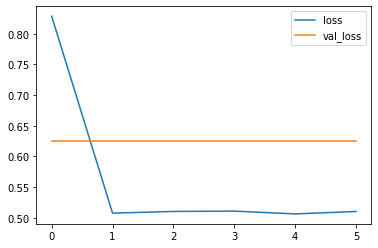

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

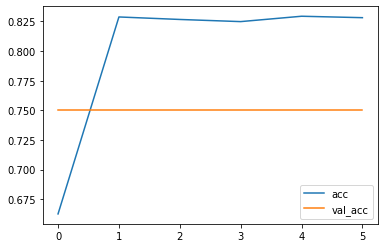

In [ ]:
# Accuracy
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

## テスト用データで予測

In [ ]:
from tensorflow.keras.models import load_model
from keras_bert import get_custom_objects

# 学習中に保存した最良モデルをロード (tensorflow2.1ではエラーになります)
model = load_model(train_model_checkpoint_path, custom_objects=get_custom_objects())

# 予測を実行
y_test_pred_proba = model.predict([X_test, np.zeros_like(X_test)])

# 先頭3つのデータを表示
y_test_pred_proba[:3]

array([[8.33343387e-01, 1.12371907e-01, 3.82885523e-02, 1.59961153e-02],
       [4.49357647e-03, 5.94640267e-04, 9.94549572e-01, 3.62182764e-04],
       [8.81493151e-01, 1.03432566e-01, 8.39951076e-03, 6.67475630e-03]],
      dtype=float32)

### 結果レポート

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_true_labels = y_test.argmax(axis=1) # Probability -> index
y_test_pred_labels = y_test_pred_proba.argmax(axis=1) # One-hot -> index

target_names = [index2label[i] for i in range(class_count)]
rep = classification_report(y_test_true_labels, y_test_pred_labels, target_names=target_names, output_dict=True)

pd.DataFrame(rep)

,グルメ,京都観光,携帯電話,スポーツ,accuracy,macro avg,weighted avg
precision,0.757576,0.796610,0.717391,0.800000,0.76,0.767894,0.765384
recall,0.714286,0.762162,0.891892,0.516129,0.76,0.721117,0.760000
f1-score,0.735294,0.779006,0.795181,0.627451,0.76,0.734233,0.755821
support,105.000000,185.000000,148.000000,62.000000,0.76,500.000000,500.000000
